In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image

In [1]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook, pycolmap
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_retrieval, localize_sfm
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

# Setup
Here we define some output paths.

In [2]:
images = Path('datasets/fastfive')
outputs = Path('outputs/fastfive-5pair')

sfm_pairs = outputs / 'pairs-sfm.txt'
# loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
loc_pairs = outputs / 'pairs-loc.txt'
# features = outputs / 'features.h5'
# matches = outputs / 'matches.h5'

retrieval_conf = extract_features.confs['netvlad']
feature_conf = extract_features.confs['superpoint_aachen']
matcher_conf = match_features.confs['superglue']

# 3D mapping
First we list the images used for mapping. 

198 mapping images


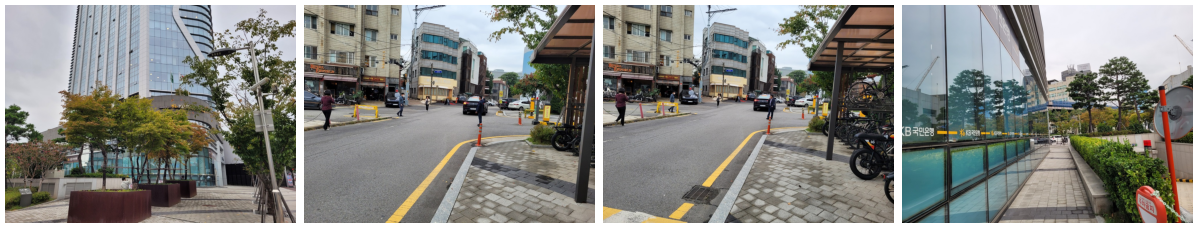

In [3]:
references = [p.relative_to(images).as_posix() for p in (images / 'mapping/').iterdir()]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references[:4]], dpi=50)

Then we extract features and match them across image pairs.  
맵핑 이미지의 global feat은 NetVLAD로 추출,  
추출된 gfeat을 이용해 top 20 retrieved pair 를 만든다.  
맵핑과 쿼리 전체 이미지의 local feat은 superpoint로 추출,  
만들어진 pair와 superpoint feat를 superglue로 매칭한다. 

In [4]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs, image_list=references)

[2022/10/20 13:27:25 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/10/20 13:27:38 hloc INFO] Finished exporting features.


In [5]:
pairs_from_retrieval.main(global_descriptors, sfm_pairs, num_matched=5)

[2022/10/20 13:27:38 hloc INFO] Extracting image pairs from a retrieval database.
[2022/10/20 13:27:38 hloc INFO] Found 990 pairs.


In [6]:
feature_path = extract_features.main(feature_conf, images, outputs)

[2022/10/20 13:27:38 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}
[2022/10/20 13:27:38 hloc INFO] Found 207 images in root datasets/fastfive.


Loaded SuperPoint model


[2022/10/20 13:27:42 hloc INFO] Finished exporting features.


In [7]:
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

[2022/10/20 13:27:42 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}


Loaded SuperGlue model ("outdoor" weights)


[2022/10/20 13:29:32 hloc INFO] Finished exporting matches.


In [8]:
# global_descriptors = extract_features.main(retrieval_conf, images, outputs, image_list=references)
# pairs_from_retrieval.main(global_descriptors, sfm_pairs, num_matched=20)
# feature_path = extract_features.main(feature_conf, images, outputs)
# match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf['output'], outputs)

The we run incremental Structure-From-Motion and display the reconstructed 3D model.

In [9]:
print(sfm_pairs, feature_path, match_path, sep="\n")

outputs/fastfive-5pair/pairs-sfm.txt
outputs/fastfive-5pair/feats-superpoint-n4096-r1024.h5
outputs/fastfive-5pair/feats-superpoint-n4096-r1024_matches-superglue_pairs-sfm.h5


In [10]:
len(references)

198

In [11]:
if sfm_dir.exists(): 
    model = pycolmap.Reconstruction()
    model.read_binary(sfm_dir.as_posix())
else:
    model = reconstruction.main(sfm_dir, images, sfm_pairs, feature_path, match_path, image_list=references)

[2022/10/20 13:29:32 hloc INFO] Creating an empty database...
[2022/10/20 13:29:32 hloc INFO] Importing images into the database...
[2022/10/20 13:29:33 hloc INFO] Importing features into the database...


  0%|          | 0/198 [00:00<?, ?it/s]

[2022/10/20 13:29:33 hloc INFO] Importing matches into the database...


  0%|          | 0/990 [00:00<?, ?it/s]

[2022/10/20 13:29:34 hloc INFO] Performing geometric verification of the matches...
[2022/10/20 13:29:35 hloc INFO] Running 3D reconstruction...
W1020 13:30:06.792594  6372 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1020 13:30:06.793526  6372 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
W1020 13:30:06.794406  6372 levenberg_marquardt_strategy.cc:116] Linear solver failure. Failed to compute a step: Eigen failure. Unable to perform dense Cholesky factorization.
[2022/10/20 13:31:39 hloc INFO] Reconstructed 2 model(s).
[2022/10/20 13:31:39 hloc INFO] Largest model is #1 with 172 images.
[2022/10/20 13:31:39 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 172
	num_cameras = 1
	num_points3D = 47482
	num_observations = 289365
	mean_track_length = 6.0942
	mean_

In [12]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping")
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

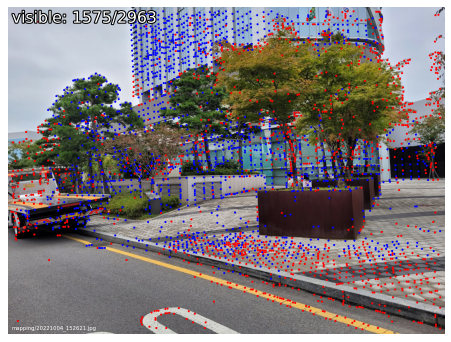

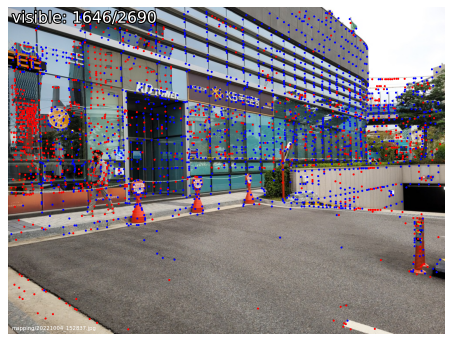

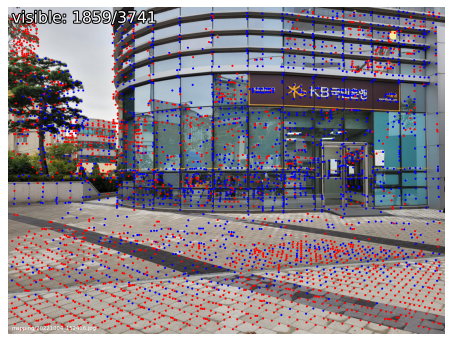

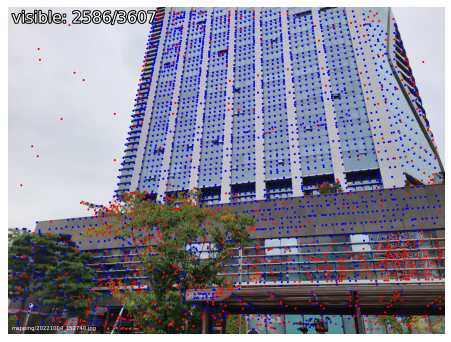

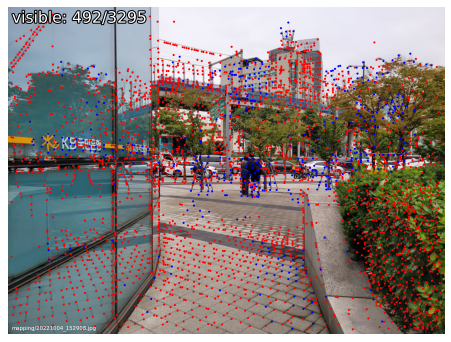

In [13]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=5)

# Localization
Now that we have a 3D map of the scene, we can localize any image. 

9 query images


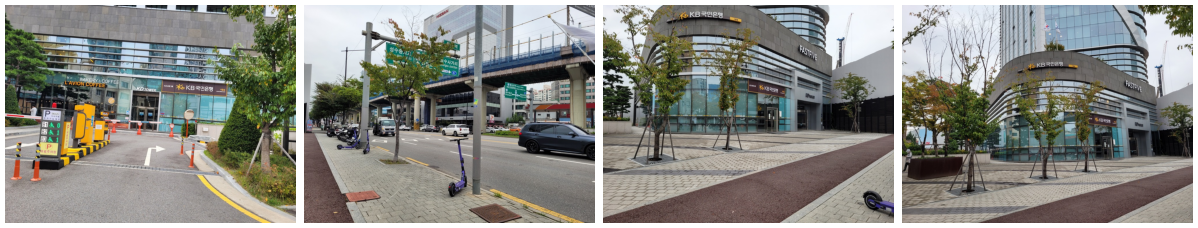

In [28]:
queries = [p.relative_to(images).as_posix() for p in (images / 'query/').iterdir()]
print(len(queries), "query images")
plot_images([read_image(images / r) for r in queries[:4]], dpi=50)

Localization을 위한 pair의 path를 지정한다.

Again, we extract features for the query and match them using retrieval method.  
쿼리 이미지들을 대상으로 아까와 똑같이 global feature를 추출한다.  
추출된 gfeat을 이용해 query 이미지와 유사한 top 20 mapping 이미지를 retrival 해서 pair를 만든다. 


In [29]:
global_descriptors = extract_features.main(retrieval_conf, images, outputs, image_list=queries)

[2022/10/18 11:32:11 hloc INFO] Extracting local features with configuration:
{'model': {'name': 'netvlad'},
 'output': 'global-feats-netvlad',
 'preprocessing': {'resize_max': 1024}}
[2022/10/18 11:32:12 hloc INFO] Skipping the extraction.


In [30]:
pairs_from_retrieval.main(global_descriptors, loc_pairs, num_matched=5, db_prefix="mapping", query_prefix="query")

[2022/10/18 11:32:12 hloc INFO] Extracting image pairs from a retrieval database.
[2022/10/18 11:32:12 hloc INFO] Found 45 pairs.


In [31]:
match_features.main(matcher_conf, loc_pairs, features=feature_path, matches=match_path)

[2022/10/18 11:32:12 hloc INFO] Matching local features with configuration:
{'model': {'name': 'superglue',
           'sinkhorn_iterations': 50,
           'weights': 'outdoor'},
 'output': 'matches-superglue'}
[2022/10/18 11:32:12 hloc INFO] Skipping the matching.


PosixPath('outputs/fastfive-5pair/feats-superpoint-n4096-r1024_matches-superglue_pairs-sfm.h5')

In [32]:
# global_descriptors = extract_features.main(retrieval_conf, images, outputs, image_list=queries)
# pairs_from_retrieval.main(global_descriptors, loc_pairs, num_matched=20, db_prefix="mapping", query_prefix="query")
# match_features.main(matcher_conf, loc_pairs, features=feature_path, matches=match_path)

In [33]:
# make query + intrinsic to text file
# format: "query_name camara_model params" each lines
camera_model = 'OPENCV' # w, h, fx, fy, cx, cy, k1, k2, p1, p2
params = [1008, 756, 765.171818, 765.171818, 504.000000, 378.000000, 0.062161, -0.047225, 0.003354, -0.002883]
with open(outputs / 'queries.txt', 'w') as f:
    for query in queries:
        f.write(f'{query} {camera_model} {" ".join(map(str, params))}\n')

In [23]:
results = outputs / 'queryresult.txt'  # the result file

localize_sfm.main(
    model, 
    outputs / 'queries.txt',
    loc_pairs,
    feature_path,
    match_path,
    results,
    covisibility_clustering=False
)

[2022/10/18 11:31:29 hloc.utils.parsers INFO] Imported 9 images from queries.txt
[2022/10/18 11:31:29 hloc INFO] Reading the 3D model...
[2022/10/18 11:31:29 hloc INFO] Starting localization...


  0%|          | 0/9 [00:00<?, ?it/s]

[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152426.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152413.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152509.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152539.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152523.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152335.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152402.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152336.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152538.jpg was retrieved but not in database
[2022/10/18 11:31:29 hloc WARNING] Image mapping/20221004_152323.jpg was 

IndexError: list index out of range

In [ ]:
visualization.visualize_loc(results, images, model, n=1, top_k_db=2, prefix='query', seed=3)

In [ ]:
import numpy as np

selected_query = 3  # start from 0
with open(results, 'r') as f:
    for i, line in enumerate(f):
        line = line.strip()
        if i == selected_query:
            qname, qvec, tvec = line.split(' ')[0], line.split(' ')[1:5], line.split(' ')[5:]
            break
# make qvec and tvec to numpy array
qvec = np.array(qvec, dtype=np.float32)
tvec = np.array(tvec, dtype=np.float32)
print(qname, qvec, tvec)

In [ ]:
query = 'query/20221004_153100.jpg'
plot_images([read_image(images / query)], dpi=75)

In [ ]:
import pycolmap
import copy
pose = pycolmap.Image(tvec=tvec, qvec=qvec)
camera = pycolmap.infer_camera_from_image(images / 'query' / qname)
query_fig = copy.deepcopy(fig)
viz_3d.plot_camera_colmap(query_fig, pose, camera, color='rgba(0,255,0,0.5)', name=query)
query_fig.show()

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

In [ ]:
from PIL import Image
from PIL.ExifTags import TAGS, GPSTAGS
from decimal import Decimal

'''Converts the GPS coordinates stored in the EXIF to degress in float format'''
def decimal_coords(coords, ref):
    decimal_degrees = Decimal(str(coords[0])) + Decimal(str(coords[1])) / 60 + Decimal(str(coords[2])) / 3600
    if ref == "S" or ref == "W":
        decimal_degrees = -decimal_degrees
    # print(decimal_degrees)
    # round(decimal_degrees, 8)
    return round(decimal_degrees, 8)

'''
extract time and gps from exif and save to file
format: "img_name yyyy:mm:dd hh:mm:ss lat lon alt
'''
def extract_img_data(img_path, output_path):
    with open(output_path, 'w') as f:
        for img in img_path.iterdir():
            img_name = img_path.name + '/' + img.name
            # img = Image.open(img)
            # exif = img._getexif()
            exif = Image.open(img)._getexif()
            if exif is None:
                f.write(f'{img_name} 0 0 0 0 0')
                continue
            time = exif[36867]
            gps = exif[34853]
            lat = decimal_coords(gps[2], gps[1])
            lon = decimal_coords(gps[4], gps[3])
            if (type(gps[5]) == bytes):
                alt_ref = int.from_bytes(gps[5], byteorder='little')
            else:
                alt_ref = gps[5]
            if alt_ref == 0:
                alt = gps[6]
            else:
                alt = -gps[6]
            f.write(f'{img_name} {time} {lat} {lon} {alt}\n')


data_path = Path('datasets/fastfive')
img_path = data_path / 'mapping'
img_data = data_path / 'image_data.txt'

extract_img_data(img_path, img_data)


In [ ]:
%pip install folium
import folium

In [ ]:
# # mark the location of the mapping images on the map using folium
# def mark_map(img_data, output_path):
#     m = folium.Map(location=[0, 0], zoom_start=14)
#     with open(img_data, 'r') as f:
#         for line in f:
#             img_name, date, time, lat, lon, alt = line.split(' ')
#             folium.Marker([lat, lon], popup=img_name).add_to(m)
#     m.save(output_path)

image_data = data_path / 'image_data.txt'

m = folium.Map(location=[37.548642, 127.044125], zoom_start=40)
with open(img_data, 'r') as f:
    for line in f:
        img_name, date, time, lat, lon, alt = line.split(' ')
        folium.Marker([lat, lon], popup=img_name).add_to(m)
m